# Lung Cancer Risk score

## Data Preprocessing

In [1]:
import warnings
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report,roc_auc_score, roc_curve
from functools import reduce
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
print(pd.__version__)

0.25.0


In [3]:
data = pd.read_csv('lungcancer(normalized).csv')


In [4]:
data=data.iloc[:,2:]
data = data.drop(['RaceOther Race - Including Multi-Racial'], axis=1)
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 28 columns):
Gender                                          829 non-null int64
Mexican_American                                829 non-null int64
Other_Hispanic                                  829 non-null int64
NonHispanic_White                               829 non-null int64
NonHispanic_Black                               829 non-null int64
NonHispanic_Asian                               829 non-null int64
Close_Relative_Heart_Attack                     829 non-null int64
Close_Relative_Asthma                           829 non-null int64
Close_Relative_Diabetes                         829 non-null int64
Overweight                                      829 non-null int64
Lack_Exercise                                   829 non-null int64
High_Salt                                       829 non-null int64
Hight_Fat_Calories                              829 non-null int64
Have_Chronic_bronchitis 

In [29]:
Y=data['y']
X=data.ix[:,:-1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
trainDf = pd.concat([Y_train, X_train], axis=1)
testDf = pd.concat([Y_test, X_test], axis=1)
clasTest = testDf.groupby('y')['y'].count()
print(clasTest)

y
0    248
1      1
Name: y, dtype: int64


In [30]:
print(X.shape)
from collections import Counter
Counter(Y)

(829, 27)


Counter({0: 826, 1: 3})

## Modeling Process

## Model 1: Logistic Regression Classifier

In [7]:
X=np.asarray(X)
Y=np.asarray(Y)
X_train=np.asarray(X_train)
Y_train=np.asarray(Y_train)
X_test=np.asarray(X_test)
Y_test=np.asarray(Y_test)

In [8]:


class LogisticRegressionClassifier:

    def __init__(self, n=100):
        self.n = n

    def fit(self, X, Y, random_state=42, criterion='entropy'):
        X_train_p = X[Y==1]
        X_train_n = X[Y==0]
        Y_train_p = Y[Y==1]
        Y_train_n = Y[Y==0]
        l = sum(Y_train_p)
        clf_list = []
        np.random.seed(seed=random_state)
        for i in range(self.n):
            idx_n = np.random.choice(range(X_train_n.shape[0]), l)
            idx_p = np.random.choice(range(X_train_p.shape[0]), l)
            X_train_f = np.concatenate([X_train_n[idx_n, :], X_train_p[idx_p]])
            Y_train_f = np.concatenate([Y_train_n[idx_n], Y_train_p[idx_p]])
            clf = LogisticRegression()
            clf.fit(X_train_f, Y_train_f)
            clf_list.append(clf)
            print(f'\rClassifier {i+1} completed.', end='')
        self.clfs = clf_list        
    
    def coefficients(self):
        feature_importance = abs(self.clfs[0].coef_)
        for tree in self.clfs[1:]:
            feature_importance += tree.coef_
        return feature_importance/ self.n
    
    def predict(self, X):
        result_list = list(map(lambda clf: clf.predict_proba(X)[:,1], self.clfs))
        score = reduce(lambda a, b: a+b, result_list) / len(self.clfs)
        return score
        
    def report(self, X, Y):
        y_hat = self.predict(X)
        print(classification_report(Y_test, 1.*(y_hat>0.5)))
    def predict_proba(self,X):
        result_list = list(map(lambda clf: 100*clf.predict_proba(X)[:,1], self.clfs))
        proba = reduce(lambda a, b: a+b, result_list) / len(self.clfs)
        return proba

### Model Training

In [9]:
btc = LogisticRegressionClassifier(500)
btc.fit(X_train, Y_train)
y_hat = 1.0 * (btc.predict(X_test)>0.5)
y_hatt = 1.0 * (btc.predict(X_train)>0.5)


Classifier 500 completed.

In [10]:
btc.coefficients() # avg coefficients of n classifiers 

array([[ 1.74128347e-03, -5.73284819e-02, -5.30250891e-02,
         3.56094078e-02,  1.21423842e-01, -3.15433823e-02,
         1.58876411e-01,  1.26217911e-01,  1.58899612e-02,
        -1.50487145e-01,  2.14921098e-01,  5.66844296e-02,
         4.53909833e-02,  1.95858635e-01,  2.38181285e-01,
         6.65175642e-02,  3.91917324e-01, -6.13982287e-02,
         3.10577118e-01, -7.74489380e-03, -1.72954050e-02,
         2.00394700e-01, -9.90328609e-05,  9.31307310e-06,
        -1.13095661e-04, -2.89134346e-05, -1.95206001e-02]])

### Risk Score of test data

In [9]:

reshaped_X_test = pd.DataFrame(X_test)
reshaped_X_test.index = np.arange(0,len(X_test))
reshaped_risk_score = pd.DataFrame(btc.predict_proba(X_test).reshape(-1,1))

predictors_name = pd.DataFrame(data[data.columns[0:-1]].columns)
predictors_name.loc[predictors_name.index.max() + 1] = "Risk Score"
risk_score = pd.concat([reshaped_X_test,reshaped_risk_score], axis=1, ignore_index=True)
risk_score.columns = ["Gender","NonHispanic_White","NonHispanic_Black", "Mexican_American", "Other_Hispanic", "NonHispanic_Asian", "Close_Relative_Heart_Attack","Close_Relative_Asthma","Close_Relative_Diabetes","Overweight","Lack_Exercise","High_Salt","Hight_Fat_Calories","Have_Chronic_bronchitis","Smoked_at_least_100_cigarettes_in_life","Smoked_a_cigar_even_one_time","Ever_used_an_ecigarette","Ever_used_smokeless_tobacco","Ever_had_pain_or_discomfort_in_chest","Breathe_paint_fumes_past_48hours","Breathe_diesel_fumes_past_48hours","Breathe_fingernail_polish_fumes_past_48hours","Age","Exposure_to_secondhand_smoke","Urinary_arsenic_total_(ug/L)","Chromium_(nmol/L)","AVG_Betacarotene","Risk_Score"]                
risk_score.head()                 

,Gender,NonHispanic_White,NonHispanic_Black,Mexican_American,Other_Hispanic,NonHispanic_Asian,Close_Relative_Heart_Attack,Close_Relative_Asthma,Close_Relative_Diabetes,Overweight,...,Ever_had_pain_or_discomfort_in_chest,Breathe_paint_fumes_past_48hours,Breathe_diesel_fumes_past_48hours,Breathe_fingernail_polish_fumes_past_48hours,Age,Exposure_to_secondhand_smoke,Urinary_arsenic_total_(ug/L),Chromium_(nmol/L),AVG_Betacarotene,Risk_Score
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.002885,0.000000,0.000265,0.000201,0.140786,50.275049
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.001623,0.000036,0.000544,0.000201,0.001154,39.323288
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.001803,0.000000,0.001168,0.000201,0.050823,34.110037
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.002776,0.000072,0.000267,0.000201,0.076117,36.562345
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.001839,0.000000,0.000251,0.000201,0.087295,38.556954


In [10]:
reshaped_cof = pd.DataFrame(btc.coefficients().reshape(-1,1))
predictors_final = pd.DataFrame(data[data.columns[2:]].columns)
predictors_final.index = np.arange(1,len(predictors_final)+1)
reshaped_cof.index =  np.arange(1,len(reshaped_cof)+1)

In [11]:
coefficient_tb1= pd.concat([predictors_final,reshaped_cof], axis=1, ignore_index=True)
coefficient_tb2 = coefficient_tb1.rename(columns={0: "Predictor", 1: "Coefficient"})
coefficient_tb_final = coefficient_tb2.sort_values(by=["Coefficient"],ascending=False)
coefficient_tb_final.head(10)
#coefficient_tb_final.to_csv('coefficient_tb_final.csv')

,Predictor,Coefficient
17,Ever_had_pain_or_discomfort_in_chest,0.391917
19,Breathe_diesel_fumes_past_48hours,0.310577
15,Ever_used_an_ecigarette,0.238181
11,Hight_Fat_Calories,0.214921
22,Exposure_to_secondhand_smoke,0.200395
14,Smoked_a_cigar_even_one_time,0.195859
7,Close_Relative_Diabetes,0.158876
8,Overweight,0.126218
5,Close_Relative_Heart_Attack,0.121424
16,Ever_used_smokeless_tobacco,0.066518


### Model Prediction Accuracy

In [12]:
print(classification_report(y_true=Y_train, y_pred=y_hatt))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       578
           1       0.04      1.00      0.07         2

    accuracy                           0.91       580
   macro avg       0.52      0.96      0.51       580
weighted avg       1.00      0.91      0.95       580



In [12]:
print(classification_report(y_true=Y_test, y_pred=y_hat))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94       248
           1       0.00      0.00      0.00         1

    accuracy                           0.89       249
   macro avg       0.50      0.45      0.47       249
weighted avg       0.99      0.89      0.94       249



In [13]:
confusion_matrix(y_true=Y_test, y_pred=y_hat)

array([[222,  26],
       [  1,   0]])

### Feature importance

In [15]:
feature_importance = abs(coefficient_tb_final[coefficient_tb_final.columns[1]])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

score = feature_importance.head(10)
predictors_10 = coefficient_tb_final[coefficient_tb_final.columns[0]].head(10)
feature_importance_table = pd.concat([predictors_10,score], axis=1)
feature_importance_table
feature_importance_table_desc = feature_importance_table.sort_values(by=["Coefficient"],ascending=True)
feature_importance_table_desc

,Predictor,Coefficient
16,Ever_used_smokeless_tobacco,16.972346
5,Close_Relative_Heart_Attack,30.982004
8,Overweight,32.205239
7,Close_Relative_Diabetes,40.538247
14,Smoked_a_cigar_even_one_time,49.974478
22,Exposure_to_secondhand_smoke,51.131881
11,Hight_Fat_Calories,54.838377
15,Ever_used_an_ecigarette,60.773349
19,Breathe_diesel_fumes_past_48hours,79.245570
17,Ever_had_pain_or_discomfort_in_chest,100.000000


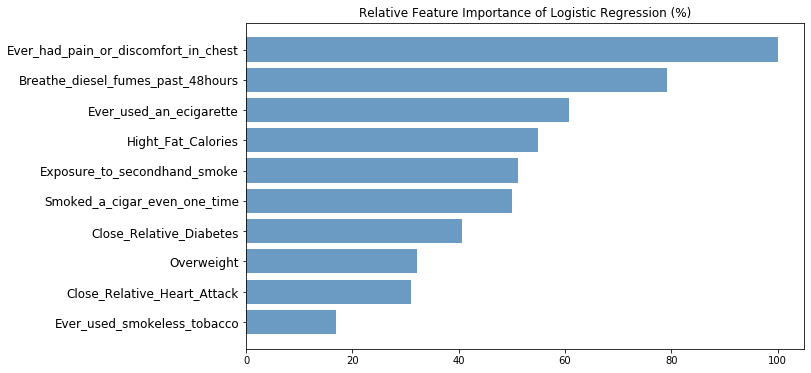

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,6))

share = feature_importance_table_desc[feature_importance_table_desc.columns[1]]
plt.barh(range(10), share, align = 'center',color='steelblue', alpha = 0.8)

plt.yticks(range(10),feature_importance_table_desc[feature_importance_table_desc.columns[0]], fontsize=12)
#ax.set_xlabels('Relative Feature Importance (%)')
#xticks(np.arange(10), ['Tom', 'Dick', 'Sue',]) 
#plt.tight_layout()   
plt.title('Relative Feature Importance of Logistic Regression (%)')
plt.show()

In [11]:
a = btc.predict_proba(X_test)/100
auc = roc_auc_score(Y_test, a)
print('AUC: %.2f' % auc)

AUC: 0.77


In [12]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [13]:
fpr, tpr, thresholds = roc_curve(Y_test, a)
for i, value in enumerate(thresholds):
    print("%f %f %f" % (fpr[i], tpr[i], value))

0.000000 0.000000 1.675408
0.004032 0.000000 0.675408
0.225806 0.000000 0.441809
0.229839 1.000000 0.441715
1.000000 1.000000 0.272650


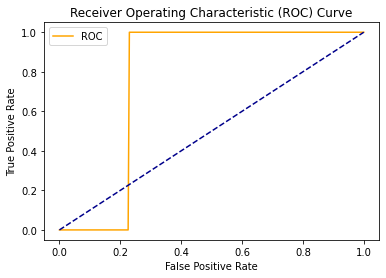

In [14]:
plot_roc_curve(fpr, tpr)

In [15]:
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 



In [16]:
threshold = Find_Optimal_Cutoff(Y_test, a)
threshold

[0.4417150518524771]

In [17]:
fprr, tprr, thresholdss = roc_curve(Y_test, a)
J = tprr - fprr
ix = np.argmax(J)
best_thresh = thresholdss[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.441715


In [18]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tprr * (1-fprr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholdss[ix], gmeans[ix]))

Best Threshold=0.441715, G-Mean=0.878


In [20]:
y_hat_new = 1.0 * (btc.predict(X_test)>0.4417150518524771)
print(classification_report(Y_test,y_hat_new))
print(confusion_matrix(Y_test,y_hat_new))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87       248
           1       0.00      0.00      0.00         1

    accuracy                           0.77       249
   macro avg       0.50      0.39      0.44       249
weighted avg       0.99      0.77      0.87       249

[[192  56]
 [  1   0]]


### XGBoost Tree

In [31]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [7]:


# find the best parameter

nmc = 100 

# set up dictionary for grid search
#  dictionary name must now include pipeline function name then __

n_estimators = 100
max_depth = range(3,10,2)
gamma = [i/10.0 for i in range(0,5)]
min_child_weight = range(1,6,2)
max_delta_step = [i for i in range(1,10)]

param_grid={'gamma': gamma,'max_depth': max_depth,'min_child_weight': min_child_weight,"max_delta_step": max_delta_step}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.2,n_splits=nmc,random_state=25)
# set up search
grid_search=GridSearchCV(XGBClassifier(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,Y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','param_max_depth','param_min_child_weight','param_gamma','param_max_delta_step']])


    rank_test_score  mean_test_score param_max_depth param_min_child_weight  \
0                 1         0.996205               3                      1   
1                 1         0.996205               3                      3   
2                 1         0.996205               3                      5   
3                 1         0.996205               5                      1   
4                 1         0.996205               5                      3   
5                 1         0.996205               5                      5   
6                 1         0.996205               7                      1   
7                 1         0.996205               7                      3   
8                 1         0.996205               7                      5   
9                 1         0.996205               9                      1   
10                1         0.996205               9                      3   
11                1         0.996205               9

In [32]:
# use best parameters: max_depth= 3, min_child_weight= 5, gamma=0.3
xgb = XGBClassifier(
 max_depth= 3, 
 min_child_weight= 5,
 gamma=0.3,
 learning_rate =0.1,
 n_estimators=1000,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
max_delta_step = 10)


xgb.fit(X_train,Y_train)
print('Training score:', xgb.score(X_train,Y_train))
print('Testing score:',xgb.score(X_test,Y_test))


Training score: 0.996551724137931
Testing score: 0.9959839357429718


no severe overfitting problems

In [20]:
# confusion matrix
        
pred = xgb.predict(X_test)
predd = xgb.predict(X_train)
confusion_matrix(y_true=Y_test, y_pred=pred)

array([[248,   0],
       [  1,   0]])

In [18]:
print(classification_report(y_true=Y_test, y_pred=pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248
           1       0.00      0.00      0.00         1

    accuracy                           1.00       249
   macro avg       0.50      0.50      0.50       249
weighted avg       0.99      1.00      0.99       249



In [19]:
print(classification_report(y_true=Y_train, y_pred=predd))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       578
           1       0.00      0.00      0.00         2

    accuracy                           1.00       580
   macro avg       0.50      0.50      0.50       580
weighted avg       0.99      1.00      0.99       580



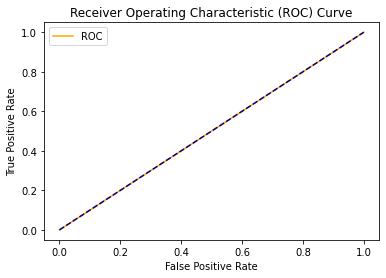

In [33]:
## ROC Curve
b = xgb.predict_proba(X_test)[:,1]
roc_auc_score(Y_test,b)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(Y_test, b)
plot_roc_curve(fpr_xgb,tpr_xgb)

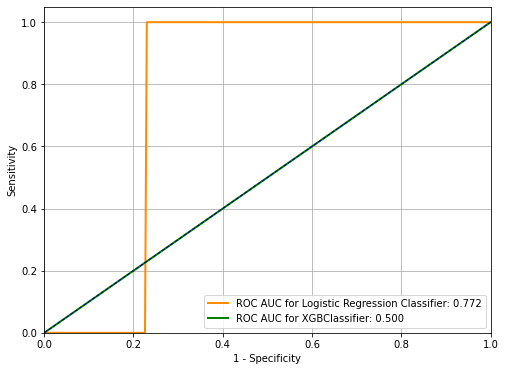

In [34]:
def roc_curve_and_score(Y_test, pred_proba):
    fpr, tpr, _ = roc_curve(Y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(Y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc
plt.figure(figsize=(8, 6))
#matplotlib.rcParams.update({'font.size': 14})
plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, a)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC AUC for Logistic Regression Classifier: {0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, b)
plt.plot(fpr, tpr, color='green', lw=2,label='ROC AUC for XGBClassifier: {0:.3f}'.format(roc_auc))
#fpr, tpr, roc_auc = roc_curve_and_score(y_test, mlp_prediction_proba) 
#plt.plot(fpr, tpr, color='crimson', lw=2,label='ROC AUC={0:.3f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

# Risk Score

In [91]:
risk_score = 100*xgb.predict_proba(X).reshape(-1,1)



In [92]:

reshaped_X_test = pd.DataFrame(X)
reshaped_X_test.index = np.arange(0,len(X))
reshaped_risk_score = pd.DataFrame(risk_score)

predictors_name = pd.DataFrame(data[data.columns[0:-1]].columns)
predictors_name.loc[predictors_name.index.max() + 1] = "Risk Score"
risk_score = pd.concat([reshaped_X_test,reshaped_risk_score], axis=1, ignore_index=True)
risk_score.columns = ["Gender","Mexican_American","Other_Hispanic","NonHispanic_White","NonHispanic_Black",  "NonHispanic_Asian","Close_Relative_Heart_Attack","Close_Relative_Asthma","Close_Relative_Diabetes","Overweight","Lack_Exercise","High_Salt","Hight_Fat_Calories","Have_Chronic_bronchitis","Smoked_at_least_100_cigarettes_in_life","Smoked_a_cigar_even_one_time","Ever_used_an_ecigarette","Ever_used_smokeless_tobacco","Ever_had_pain_or_discomfort_in_chest","Breathe_paint_fumes_past_48hours","Breathe_diesel_fumes_past_48hours","Breathe_fingernail_polish_fumes_past_48hours","Age","Exposure_to_secondhand_smoke","Urinary_arsenic_total_(ug/L)","Chromium_(nmol/L)","AVG_Betacarotene","Risk_Score"]
                  
risk_score.head()                

,Gender,Mexican_American,Other_Hispanic,NonHispanic_White,NonHispanic_Black,NonHispanic_Asian,Close_Relative_Heart_Attack,Close_Relative_Asthma,Close_Relative_Diabetes,Overweight,...,Ever_had_pain_or_discomfort_in_chest,Breathe_paint_fumes_past_48hours,Breathe_diesel_fumes_past_48hours,Breathe_fingernail_polish_fumes_past_48hours,Age,Exposure_to_secondhand_smoke,Urinary_arsenic_total_(ug/L),Chromium_(nmol/L),AVG_Betacarotene,Risk_Score
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.002236,0.000000,0.000049,0.000201,0.118881,99.661194
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.001911,0.000036,0.000233,0.000201,0.029026,0.338806
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.002812,0.000036,0.000586,0.000201,0.051706,99.661194
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.002055,0.000000,0.000169,0.000201,0.066021,0.338806
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.002885,0.000000,0.000141,0.000201,0.046208,99.661194


## Feature Importance

In [93]:
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [94]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

## Visualize a single prediction

In [95]:
X_test = pd.DataFrame(X_test)
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[3,:])

In [96]:
shap.force_plot(explainer.expected_value, shap_values[:1636,:], X.iloc[:1636,:])

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

## SHAP Summary Plot
Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

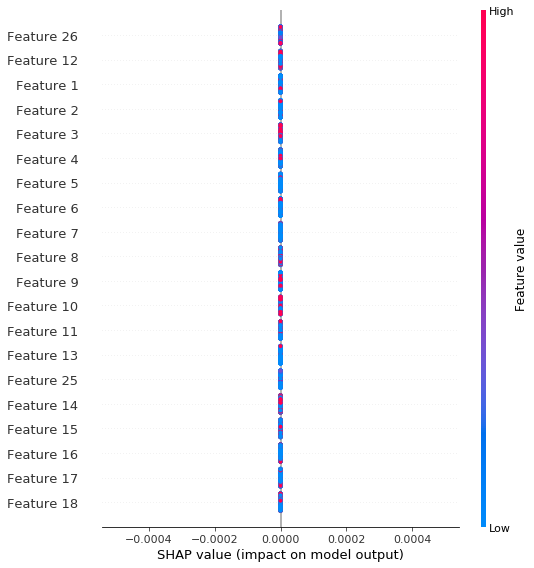

In [97]:
shap.summary_plot(shap_values, X)

## Bar chart of mean importance
This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

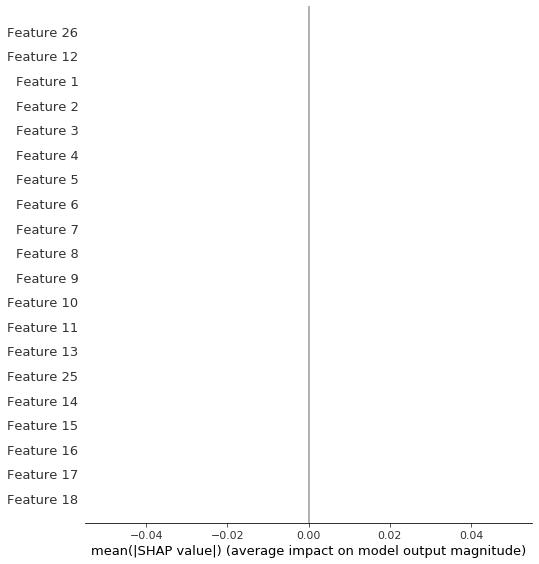

In [80]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [102]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.cross_validation import train_test_split
from costcla.datasets import load_creditscoring1
from costcla.models import CostSensitiveDecisionTreeClassifier
from costcla.metrics import savings_score


In [105]:
data = load_creditscoring1()
sets = train_test_split(data.data, data.target, data.cost_mat, test_size=0.33, random_state=0)
X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = sets
y_pred_test_rf = RandomForestClassifier(random_state=0).fit(X_train, y_train).predict(X_test)
f = CostSensitiveDecisionTreeClassifier()
y_pred_test_csdt = f.fit(X_train, y_train, cost_mat_train).predict(X_test)
# Savings using only RandomForest
print(savings_score(y_test, y_pred_test_rf, cost_mat_test))
0.12454256594
# Savings using CSDecisionTree
print(savings_score(y_test, y_pred_test_csdt, cost_mat_test))


0.1415583959728257
0.48191613552940005


In [110]:
data


{'data': array([[ 0.76612661, 45.        ,  2.        , ...,  6.        ,
          0.        ,  2.        ],
        [ 0.95715102, 40.        ,  0.        , ...,  0.        ,
          0.        ,  1.        ],
        [ 0.65818014, 38.        ,  1.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.29974515, 44.        ,  0.        , ...,  1.        ,
          0.        ,  2.        ],
        [ 0.        , 30.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.85028295, 64.        ,  0.        , ...,  2.        ,
          0.        ,  0.        ]]),
 'target': array([1, 0, 0, ..., 0, 0, 0]),
 'cost_mat': array([[ 1023.73054104, 18750.        ,     0.        ,     0.        ],
        [  694.27379722,  5849.25      ,     0.        ,     0.        ],
        [  719.67113704,  6843.75      ,     0.        ,     0.        ],
        ...,
        [  865.73457105, 12563.25      ,     0.        ,     0.        ],
 